In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/test_features.csv


In [2]:
import gc
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skmultilearn.model_selection.iterative_stratification import IterativeStratification, iterative_train_test_split

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

import math

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# References

https://www.kaggle.com/elcaiseri/moa-keras-multilabel-classifier-nn-starter

# Read in Data

In [3]:
base_path = '/kaggle/input/lish-moa/'

train_features = pd.read_csv(os.path.join(base_path, 'train_features.csv'))
test_features = pd.read_csv(os.path.join(base_path, 'test_features.csv'))

train_targets = pd.read_csv(os.path.join(base_path, 'train_targets_scored.csv'))
train_targets_nonscored = pd.read_csv(os.path.join(base_path, 'train_targets_nonscored.csv'))
submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))


# Preprocess

In [4]:
def preprocess_data(df):

    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})    
    #df = pd.get_dummies(df, columns=['cp_time','cp_dose'])
    
    del df['sig_id']
    
    return df

In [5]:
train_x = preprocess_data(train_features)
train_y = train_targets.copy()
train_y.drop('sig_id', axis=1, inplace=True)
train_y_nonscored = train_targets_nonscored.copy()
train_y_nonscored.drop('sig_id', axis=1, inplace=True)
test = preprocess_data(test_features)

In [6]:
# take out targets with no activations in the nonscored target table

target_act_count = train_y_nonscored.sum(axis=0).sort_values()
zeros_targets = list(target_act_count[target_act_count==0].index)
train_y_nonscored = train_y_nonscored[[c for c in train_y_nonscored.columns if c not in zeros_targets]]

# Feature Engineering

## Stats from features

https://www.kaggle.com/ragnar123/moa-dnn-feature-engineering

In [7]:
# Function to extract common stats features
def fe_stats(train, test):
    
    features_g = [c for c in train.columns if 'g-' in c]
    features_c = [c for c in train.columns if 'c-' in c]
    
    for df in [train, test]:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
    return train, test


def c_squared(train, test):
    
    features_c = [c for c in train.columns if 'c-' in c]
    for df in [train, test]:
        for feature in features_c:
            feature_alt = feature.replace('-','_')
            df[f'{feature_alt}_squared'] = df[feature] ** 2
    return train, test


def fe_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 123):
    
    features_g = [c for c in train.columns if 'g-' in c]
    features_c = [c for c in train.columns if 'c-' in c]
    
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    
    return train, test

In [8]:
train_x, test = fe_cluster(train_x, test)
train_x, test = fe_stats(train_x, test)
train_x, test = c_squared(train_x, test)

## Standardize

### RankGauss

- This was showing better performance compare to MinMaxScaler

In [9]:
features = [c for c in train_x.columns if 'cp_' not in c]

for col in features:

    transformer = preprocessing.QuantileTransformer(n_quantiles=100,random_state=0,
                                                    output_distribution="normal")
    vec_len = len(train_x[col].values)
    vec_len_test = len(test[col].values)
    raw_vec = train_x[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_x[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test[col] = transformer.transform(test[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

### MinMaxScaler

In [10]:
# scaler = preprocessing.MinMaxScaler()
# scaler.fit(train_x)

# train_trans = scaler.transform(train_x)
# test_trans = scaler.transform(test)

# train_x = pd.DataFrame(train_trans, columns=train_x.columns)
# test = pd.DataFrame(test_trans, columns=test.columns)

## PCA

- During the EDA process, we saw a lot of correlations among the gene and cell features (especially cell), so we'll use PCA to reduce our feature space

Text(0, 0.5, 'cumulative explained variance')

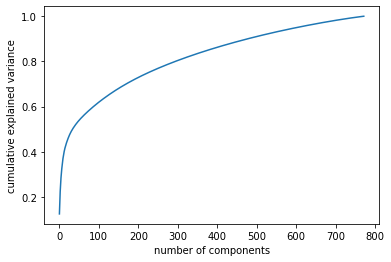

In [11]:
g_features = [c for c in train_x.columns if 'g-' in c]
g_feature_train = train_x[g_features].copy()

pca = PCA().fit(g_feature_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [12]:
def apply_pca(pca, feature_df, col_type='g'):
    
    projected_df = pca.transform(feature_df)
    projected_df = pd.DataFrame(projected_df)
    projected_df.columns = [col_type+'_component_' + str(n) for n in projected_df.columns]
    
    return projected_df

In [13]:
# Keeping 95% variance
variance = 0.95
# gene features
g_features = [c for c in train_x.columns if 'g-' in c]
g_pca = PCA(variance).fit(train_x[g_features])
print(f'Number of components for gene features to keep {int(variance*100)}% variance: ', g_pca.n_components_)

transformed_g_train = apply_pca(g_pca, train_x[g_features], col_type='g')
#train_x.drop(g_features, axis=1, inplace=True)
train_x = pd.concat([train_x, transformed_g_train], axis=1)

transformed_g_test = apply_pca(g_pca, test[g_features], col_type='g')
#test.drop(g_features, axis=1, inplace=True)
test = pd.concat([test, transformed_g_test], axis=1)

Number of components for gene features to keep 95% variance:  602


In [14]:
# cell features
c_features = [c for c in train_x.columns if 'c-' in c]
c_pca = PCA(variance).fit(train_x[c_features])
print(f'Number of components for cell features to keep {int(variance*100)}% variance: ', c_pca.n_components_)

transformed_c_train = apply_pca(c_pca, train_x[c_features], col_type='c')
#train_x.drop(c_features, axis=1, inplace=True)
train_x = pd.concat([train_x, transformed_c_train], axis=1)

transformed_c_test = apply_pca(c_pca, test[c_features], col_type='c')
#test.drop(c_features, axis=1, inplace=True)
test = pd.concat([test, transformed_c_test], axis=1)

Number of components for cell features to keep 95% variance:  83


# Feature Selection

In [15]:
from sklearn.feature_selection import VarianceThreshold

In [16]:
features = [c for c in train_x.columns if 'cp_' not in c]

thresh = VarianceThreshold(0.8)
fitted = thresh.fit(train_x.loc[:, features])

train_x_transformed = train_x.loc[:, features].copy()
train_x_transformed = train_x_transformed[train_x_transformed.columns[fitted.get_support(indices=True)]]

test_features_transformed = test.loc[:, features].copy()
test_features_transformed = test_features_transformed[test_features_transformed.columns[fitted.get_support(indices=True)]]

#test_features_transformed = var_fitted.transform(test.iloc[:, 3:])


tr_features = pd.DataFrame(train_x[['cp_type','cp_time','cp_dose']].values.reshape(-1, 3),
                          columns=['cp_type','cp_time','cp_dose'])
train_x = pd.concat([tr_features, pd.DataFrame(train_x_transformed)], axis=1)


te_features = pd.DataFrame(test[['cp_type','cp_time','cp_dose']].values.reshape(-1, 3),
                            columns=['cp_type','cp_time','cp_dose'])
test = pd.concat([te_features, pd.DataFrame(test_features_transformed)], axis=1)

In [17]:
train_x.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,g_component_156,g_component_157,c_component_0,c_component_1,c_component_2,c_component_3,c_component_4,c_component_5,c_component_6,c_component_7
0,0,0,0,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,...,1.964606,-0.919256,-4.919171,1.552054,1.341573,1.461339,0.787781,1.178956,-0.030037,0.090488
1,0,2,0,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,...,-0.944428,0.118273,-5.092003,-0.378341,-0.181403,0.941975,-0.512484,-0.665863,-0.464563,0.449651
2,0,1,0,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,...,-1.403747,0.114112,1.355263,0.297862,0.288732,-0.153444,-0.045587,0.537705,0.924253,0.060457
3,0,1,0,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,...,0.575879,-1.070684,10.936555,1.142666,1.118825,-1.398768,0.073445,1.413511,-0.048360,0.520131
4,0,2,1,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,...,1.804947,-0.989905,-3.638540,0.565012,0.700291,-0.199855,0.261442,-0.289355,0.248847,-0.226713


# Modeling

In [18]:
# https://github.com/bckenstler/CLR/blob/master/clr_callback.py

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [19]:
def loss_fn(yt, yp, smoothing_rate):
    p_min = smoothing_rate
    p_max = 1 - p_min
    yp = np.clip(yp, p_min, p_max)
    return log_loss(yt, yp, labels=[0,1])

def metric(y_true, y_pred, targets, smoothing_rate):
    metrics = []
    for _target in targets:
        metrics.append(loss_fn(y_true.loc[:, _target],
                               y_pred.loc[:, _target].astype(float),
                               smoothing_rate))
    return np.mean(metrics)

In [20]:
def create_model(num_inputs, num_outputs, hidden_units, dropout_rate,
                 smoothing_rate, learning_rate):

    model = tf.keras.Sequential([tf.keras.layers.Input(num_inputs)])
    model.add(tf.keras.layers.BatchNormalization())
    actv = 'relu'

    for hidden_size in hidden_units:
        
        model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(hidden_size, activation=actv)))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(num_outputs, activation="sigmoid")))
    model.compile(optimizer=tfa.optimizers.AdamW(lr = learning_rate, weight_decay = 1e-5, clipvalue = 756), 
                 loss=BinaryCrossentropy(label_smoothing=smoothing_rate),
                 )
    
    return model

# def create_model(num_inputs, num_outputs, hidden_units, dropout_rate,
#                  smoothing_rate, learning_rate):
    
#     inp = tf.keras.layers.Input(shape = (num_inputs, ))
#     x = tf.keras.layers.BatchNormalization()(inp)
    
#     for units in hidden_units:
        
#         x = tf.keras.layers.Dense(units, activation = 'relu')(x)
#         x = tf.keras.layers.Dropout(dropout_rate)(x)
#         x = tf.keras.layers.BatchNormalization()(x)
        
#     out = tf.keras.layers.Dense(num_outputs, activation = 'sigmoid')(x)
#     model = tf.keras.models.Model(inputs = inp, outputs = out)
    
#     LR = learning_rate * strategy.num_replicas_in_sync
    
#     model.compile(optimizer = tf.optimizers.Adam(LR),
#                   loss=BinaryCrossentropy(label_smoothing=smoothing_rate))
    
#     return model

In [21]:
def transfer_weight(model_source ,model_dest):
    print('Transfering weights')
    for i in range(len(model_source.layers[:-1])):
        model_dest.layers[i].set_weights(model_source.layers[i].get_weights())
    
    print('Done')
    return model_dest

## Tune Parameters

https://www.kaggle.com/gogo827jz/hyperparameter-tuning-for-neural-network-on-tpu

In [22]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [23]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


In [24]:
def optimise(params):
    
    hidden_units = [params['hidden_unit_1'], params['hidden_unit_2'], params['hidden_unit_3']]
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    smoothing_rate = params['smoothing_rate']
    nfolds = 3
    
    column_idx = [i for i in range(train_x.shape[1])]
    features = list(train_x.columns)

    losses = []
    res_nn = train_y.copy()
    res_nn.loc[:, train_y.columns] = 0
    
    seed = 42
    tf.random.set_seed(seed)
    stratified_k_fold = IterativeStratification(n_splits=nfolds, order=1, random_state = seed)
    for n, (tr, val) in enumerate(stratified_k_fold.split(train_x, train_y)):

        checkpoint_path = f'Tuning:Seed:{seed}:Fold:{n}.hdf5'
        cb_checkpt = ModelCheckpoint(checkpoint_path, monitor = 'val_loss', verbose=0,
                                     save_best_only = True, save_weights_only = True, mode = 'min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=1e-6, patience=3,
                                           verbose=0, mode='min')
        early = EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=10,
                              verbose=0)

        with strategy.scope():
            model = create_model(len(features), len(train_y.columns),
                                 hidden_units=hidden_units, dropout_rate=dropout_rate,
                                smoothing_rate=smoothing_rate, learning_rate=learning_rate)

        history = model.fit(train_x.values[tr][:, column_idx],
                            train_y.values[tr],
                            validation_data=(train_x.values[val][:, column_idx], train_y.values[val]),
                            epochs=60, batch_size = 128 * strategy.num_replicas_in_sync, 
                            callbacks=[reduce_lr_loss, cb_checkpt, early],
                            verbose=0
                             )
        hist = pd.DataFrame(history.history)

        val_predictions = model.predict(train_x.values[val][:, column_idx])
        res_nn.loc[val, train_y.columns] += val_predictions
        res_nn.loc[train_x['cp_type'] == 1, train_y.columns] = 0

        loss = metric(train_y.loc[val, train_y.columns], 
                      res_nn.loc[val, train_y.columns],
                      targets=list(train_y.columns),
                      smoothing_rate=smoothing_rate)
        losses.append(loss)
        print(f'OOF Metric For SEED {seed} + FOLD {n+1} : {loss}')
        print('+-' * 10)
        
        K.clear_session()
        del model, history, hist
        x = gc.collect()

    print(losses)
    return np.mean(losses)
    

In [25]:
# param_space = {'hidden_unit_1': hp.choice('hidden_unit_1', [4096, 2048, 1024, 512]), 
#                'hidden_unit_2': hp.choice('hidden_unit_2', [4096, 2048, 1024, 512]), 
#                'hidden_unit_3': hp.choice('hidden_unit_3', [4096, 2048, 1024, 512]), 
#                'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
#                'learning_rate': hp.uniform('learning_rate', 1e-5, 1e-2),
#                'smoothing_rate': hp.uniform('smoothing_rate', 1e-15, 1e-10)
#               }

# trials = Trials()

# hopt = fmin(fn = optimise, 
#             space = param_space, 
#             algo = tpe.suggest, 
#             max_evals = 15, 
#             timeout = 2.9 * 60 * 60, 
#             trials = trials, 
#            )

# print(hopt)
# """
# {'dropout_rate': 0.48730130590765064, 'hidden_unit_1': 2, 'hidden_unit_2': 2,
# 'hidden_unit_3': 3, 'learning_rate': 0.005462817520018712, 'smoothing_rate': 1.568544957309706e-11}
# """

## Train + Predict

In [26]:
#HIDDEN_UNITS = [248, 1024, 512]
HIDDEN_UNITS = [1024, 1024, 1024]
DROPOUT_RATE = 0.2
LEARNING_RATE = 1e-3
SMOOTHING_RATE = 1e-15

submission_predictions = submission.copy()
submission_predictions.loc[:, train_y.columns] = 0

val_losses = []
train_losses = []

nonscored_historys = dict()
historys = dict()
column_idx = [i for i in range(train_x.shape[1])]

# nonscored_clr = CyclicLR(base_lr=1e-3, max_lr=0.006, step_size=2000, mode='triangular')
scored_clr = CyclicLR(base_lr=1e-3, max_lr=0.006, step_size=2000, mode='triangular')

In [27]:
# # train on nonscored first for transfer learning
# print('Training on nonscored')

# train_y_nonscored.loc[train_features['cp_type']=='ctl_vehicle', train_y_nonscored.columns] = 0
# # pulled from eda notebook
# high_corr_columns = ['abc_transporter_expression_enhancer',
#                      'diacylglycerol_o_acyltransferase_inhibitor',
#                      'dna_methyltransferase_inhibitor',
#                      'dna_methyltransferase_inhibitor',
#                      'glucocorticoid_receptor_antagonist',
#                      'glutathione_reductase_(nadph)_activators',
#                      'glutathione_reductase_(nadph)_activators',
#                      'heme_oxygenase_activators',
#                      'heme_oxygenase_activators',
#                      'hiv_protease_inhibitor',
#                      'keap1_ligand',
#                      'macrophage_migration_inhibiting_factor_inhibitor',
#                      'nfkb_activator',
#                      'quorum_sensing_signaling_modulator',
#                      'ror_inverse_agonist',
#                      'sars_coronavirus_3c-like_protease_inhibitor',
#                      'steryl_sulfatase_inhibitor']

# target_nonscored = train_y_nonscored[high_corr_columns].copy()

# X_train_nonscored, y_train_nonscored, X_test_nonscored, y_test_nonscored = iterative_train_test_split(train_x.values, target_nonscored.values, 0.1)
# print(f"======{y_train_nonscored.shape}========{y_test_nonscored.shape}=====")

# checkpoint_path = f'nonscored_model.hdf5'
# cb_checkpt = ModelCheckpoint(checkpoint_path, monitor = 'val_loss', verbose=1,
#                              save_best_only = True, save_weights_only = True, mode = 'min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=1e-6, patience=3,
#                                    verbose=1, mode='min')
# early = EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=10,
#                       verbose=1)

# model_nonscored = create_model(X_train_nonscored.shape[1], y_train_nonscored.shape[1],
#                               hidden_units=HIDDEN_UNITS, dropout_rate=DROPOUT_RATE)
# nonscored_history = model_nonscored.fit(X_train_nonscored, y_train_nonscored,
#                                         validation_data=(X_test_nonscored, y_test_nonscored),
#                                         epochs=60, batch_size=128,
#                                         callbacks=[reduce_lr_loss, cb_checkpt, early],
#                                         verbose=1
#                      )
# nonscored_historys[f'nonscored_history_SEED={seed}_FOLD={n+1}'] = nonscored_history

In [28]:
NFOLDS = 5
ITERATIONS = 3

for iteration in range(ITERATIONS):
    
    seed = random.randint(1, 1000)
    #seed = 42 # test
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    stratified_k_fold = IterativeStratification(n_splits=NFOLDS, order=1, random_state = seed)
    for n, (tr, val) in enumerate(stratified_k_fold.split(train_x, train_y)):


        checkpoint_path = f'repeat:Seed:{seed}:Fold:{n}.hdf5'
        cb_checkpt = ModelCheckpoint(checkpoint_path, monitor = 'val_loss', verbose=1,
                                     save_best_only = True, save_weights_only = True, mode = 'min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=1e-6, patience=3,
                                           verbose=1, mode='min')
        early = EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=10,
                              verbose=1)

        # train on nonscored first for transfer learning
#         print('Training on nonscored')
#         print(f"======{train_y_nonscored.values[tr].shape}========{train_y_nonscored.values[val].shape}=====")
#         model_nonscored = create_model(len(features), len(train_y_nonscored.columns),
#                                       hidden_units=HIDDEN_UNITS, dropout_rate=DROPOUT_RATE)
#         nonscored_history = model_nonscored.fit(train_x.values[tr][:, column_idx],
#                                                 train_y_nonscored.values[tr],
#                                                 validation_data=(train_x.values[val][:, column_idx], train_y_nonscored.values[val]),
#                                                 epochs=30, batch_size=128,
#                                                 #callbacks=[reduce_lr_loss, cb_checkpt, early, nonscored_clr],
#                                                 callbacks=[cb_checkpt, early, nonscored_clr],
#                                                 verbose=1
#                              )
#         nonscored_historys[f'nonscored_history_SEED={seed}_FOLD={n+1}'] = nonscored_history

        #model_nonscored.load_weights(checkpoint_path)

        # train actual model
        print('Training actual model')
        print(f"======{train_y.values[tr].shape}========{train_y.values[val].shape}=====")
        tr_feature = train_x.iloc[tr, column_idx].copy().reset_index(drop=True)
        tr_target = train_y.iloc[tr,:].copy().reset_index(drop=True)
        val_feature = train_x.iloc[val, column_idx].copy().reset_index(drop=True)
        val_target = train_y.iloc[val,:].copy().reset_index(drop=True)
        
        # process out control rows when training
        train_tr_target = tr_target[tr_feature['cp_type']!=1].copy().reset_index(drop=True)
        train_tr_feature = tr_feature[tr_feature['cp_type']!=1].copy().reset_index(drop=True)
        train_val_target = val_target[val_feature['cp_type']!=1].copy().reset_index(drop=True)
        train_val_feature = val_feature[val_feature['cp_type']!=1].copy().reset_index(drop=True)
        train_tr_feature.drop('cp_type', axis=1, inplace=True)
        train_val_feature.drop('cp_type', axis=1, inplace=True)

        model = create_model(train_tr_feature.shape[1], len(train_y.columns),
                             hidden_units=HIDDEN_UNITS, dropout_rate=DROPOUT_RATE,
                            smoothing_rate=SMOOTHING_RATE, learning_rate=LEARNING_RATE)
        
        #model = transfer_weight(model_nonscored, model)
        
        history = model.fit(train_tr_feature, train_tr_target,
                            validation_data=(train_val_feature, train_val_target),
                            epochs=26, batch_size=128,
                            #callbacks=[reduce_lr_loss, cb_checkpt, early],
                            callbacks=[cb_checkpt, early, scored_clr],
                            verbose=1
                             )
        historys[f'history_SEED={seed}_FOLD={n+1}'] = history

        train_predictions = tr_target.copy()
        train_predictions.loc[:, train_y.columns] = 0
        tr_idx = tr_feature.loc[tr_feature['cp_type']==0, list(train_tr_feature.columns)].index
        train_predict = model.predict(tr_feature.loc[tr_idx, list(train_tr_feature.columns)])
        
        val_predictions = val_target.copy()
        val_predictions.loc[:, train_y.columns] = 0
        val_idx = val_feature.loc[val_feature['cp_type']==0, list(train_tr_feature.columns)].index
        val_predict = model.predict(val_feature.loc[val_idx,list(train_tr_feature.columns)])
        
        test_idx = test.loc[test['cp_type']==0, list(train_tr_feature.columns)].index
        test_predict = model.predict(test.loc[test_idx, list(train_tr_feature.columns)])

        train_predictions.loc[tr_idx, train_y.columns] += train_predict
        val_predictions.loc[val_idx, train_y.columns] += val_predict
        submission_predictions.loc[test_idx, train_y.columns] += test_predict

        #val_predict = pd.DataFrame(val_predict, columns=train_y.columns)
        #val_predict.loc[val_feature['cp_type']==1, train_y.columns] = 0

        tr_loss = metric(tr_target, train_predictions,
                      targets=list(train_y.columns),
                      smoothing_rate=SMOOTHING_RATE)
        train_losses.append(tr_loss)

        val_loss = metric(val_target, val_predictions,
                      targets=list(train_y.columns),
                      smoothing_rate=SMOOTHING_RATE)
        val_losses.append(val_loss)
        print(f'OOF Metric For ITER {iteration+1} + SEED {seed} + FOLD {n+1} : {val_loss}')
        print('+-' * 10)

train_predictions.loc[:, train_y.columns] /= (NFOLDS*ITERATIONS)
submission_predictions.loc[:, train_y.columns] /= (NFOLDS*ITERATIONS)

#train_predictions.loc[train_features['cp_type']=='ctl_vehicle',  train_y.columns] = 0
#submission_predictions.loc[test_features['cp_type']=='ctl_vehicle',  train_y.columns] = 0

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training actual model
======(19051, 206)========(4763, 206)=====
Epoch 1/26
138/138 [==============================] - ETA: 0s - loss: 0.2949
Epoch 00001: val_loss improved from inf to 0.03583, saving model to repeat:Seed:779:Fold:0.hdf5
138/138 [==============================] - 12s 87ms/step - loss: 0.2949 - val_loss: 0.0358
Epoch 2/26
138/138 [==============================] - ETA: 0s - loss: 0.0267
Epoch 00002: val_loss improved from 0.03583 to 0.02184, saving model to repeat:Seed:779:Fold:0.hdf5
138/138 [==============================] - 11s 80ms/step - loss: 0.0267 - val_loss: 0.0218
Epoch 3/26
138/138 [==============================] - ETA: 0s - loss: 0.0202
Epoch 00003: val_loss improved from 0.02184 to 0.01914, saving model to repeat:Seed:779:Fold:0.hdf5
138/138 [==============================] - 11s 77ms/step - loss: 0.0202 - val_loss: 0.0191
Epoch 4/26
138/138 [==============================] - ETA: 0s - loss: 0.0185
Epoch 00004: val_loss improved from 0.01914 to 0.01787, sa

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training actual model
======(19051, 206)========(4763, 206)=====
Epoch 1/26
138/138 [==============================] - ETA: 0s - loss: 0.2913
Epoch 00001: val_loss improved from inf to 0.03772, saving model to repeat:Seed:577:Fold:0.hdf5
138/138 [==============================] - 11s 83ms/step - loss: 0.2913 - val_loss: 0.0377
Epoch 2/26
137/138 [============================>.] - ETA: 0s - loss: 0.0268
Epoch 00002: val_loss improved from 0.03772 to 0.02184, saving model to repeat:Seed:577:Fold:0.hdf5
138/138 [==============================] - 11s 80ms/step - loss: 0.0268 - val_loss: 0.0218
Epoch 3/26
138/138 [==============================] - ETA: 0s - loss: 0.0206
Epoch 00003: val_loss improved from 0.02184 to 0.01906, saving model to repeat:Seed:577:Fold:0.hdf5
138/138 [==============================] - 12s 88ms/step - loss: 0.0206 - val_loss: 0.0191
Epoch 4/26
138/138 [==============================] - ETA: 0s - loss: 0.0187
Epoch 00004: val_loss improved from 0.01906 to 0.01820, sa

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Training actual model
======(19051, 206)========(4763, 206)=====
Epoch 1/26
138/138 [==============================] - ETA: 0s - loss: 0.2223
Epoch 00001: val_loss improved from inf to 0.03028, saving model to repeat:Seed:402:Fold:0.hdf5
138/138 [==============================] - 14s 99ms/step - loss: 0.2223 - val_loss: 0.0303
Epoch 2/26
137/138 [============================>.] - ETA: 0s - loss: 0.0247
Epoch 00002: val_loss improved from 0.03028 to 0.02156, saving model to repeat:Seed:402:Fold:0.hdf5
138/138 [==============================] - 13s 93ms/step - loss: 0.0247 - val_loss: 0.0216
Epoch 3/26
137/138 [============================>.] - ETA: 0s - loss: 0.0208
Epoch 00003: val_loss improved from 0.02156 to 0.01973, saving model to repeat:Seed:402:Fold:0.hdf5
138/138 [==============================] - 11s 83ms/step - loss: 0.0208 - val_loss: 0.0197
Epoch 4/26
137/138 [============================>.] - ETA: 0s - loss: 0.0191
Epoch 00004: val_loss improved from 0.01973 to 0.01834, sa

In [29]:
# # Show Model loss in plots
# for k,v in historys.items():
#     loss = []
#     val_loss = []
#     loss.append(v.history['loss'][:40])
#     val_loss.append(v.history['val_loss'][:40])
    

# plt.figure(figsize = (15, 6))
# plt.plot(np.mean(loss, axis=0))
# plt.plot(np.mean(val_loss, axis=0))
# plt.yscale('log')
# plt.yticks(ticks=[1,1e-1,1e-2])
# plt.xlabel('Epochs')
# plt.ylabel('Average Logloss')
# plt.legend(['Training','Validation'])

In [30]:
# h = scored_clr.history
# lr = h['lr']
# loss = h['loss']
# iterations = h['iterations']

In [31]:
# try filtering out control before predicting
# try remove cluster features

In [32]:
print(f'Mean train loss: {np.mean(train_losses)}')

Mean train loss: 0.01265366657967562


In [33]:
print('Mean validation loss:', np.mean(val_losses))

Mean validation loss: 0.015641726583871498


In [34]:
submission_predictions.to_csv('submission.csv', index=False)